### Fine-tune BERT Base model for Support Ticket Dataset Classification

In [1]:
from datasets import load_dataset
from datasets import DatasetDict, Dataset

import matplotlib.pyplot as plt

from transformers import (logging,
    AutoTokenizer, DataCollatorWithPadding, 
    AutoModelForSequenceClassification, TrainingArguments, Trainer
    )
import evaluate
import numpy as np
import pandas as pd

# ignore warnings from transformers lib
logging.set_verbosity_error() 

### 1. Load data from Support Tickets Dataset

<b>1.1 Load Support Tickets Dataset fom HuggingFace Hub</b>

In [6]:
support_tickets = load_dataset("phi-ai-info/support_tickets",name='nano')

Using the latest cached version of the dataset since phi-ai-info/support_tickets couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'nano' at C:\Users\18623\.cache\huggingface\datasets\phi-ai-info___support_tickets\nano\0.0.0\bb2d0b2803655329c606fd62d6b838df8bd85796 (last modified on Mon Dec 23 16:57:00 2024).


In [7]:
support_tickets

DatasetDict({
    train: Dataset({
        features: ['subject', 'description', 'key_phrase'],
        num_rows: 60
    })
})

<b>2.1 Convert support_tickets Dataset into Pandas DataFrame</b>

In [8]:
def dataset_to_df(dataset_obj, 
                  label=None):
    cols = list(dataset_obj[0].keys())
    labels = []

    cols_values = {item:[] for item in cols}
    for json_rec in dataset_obj:
        for item in cols:
            cols_values[item].append(json_rec[item])
    
    if label is not None:
        new_key = 'label'
        cols += [new_key]
        cols_values[new_key] = []
        for json_rec in dataset_obj:
            cols_values[new_key].append(label[json_rec['key_phrase']])
    
    return pd.DataFrame({item:cols_values[item] for item in cols})

In [9]:
label_dict = {'grant access': 0,
 'revoke access': 0,
 'access profile': 0,
 'disk space': 1,
 'disk full': 1,
 'disk error': 1,
 'add user': 2,
 'delete user': 2,
 'create user': 2,
 'modify user': 2}

df_set = dataset_to_df(support_tickets['train'], 
                       label=label_dict)

df_set

In [10]:
random_index = np.random.permutation(df_set.index)
random_index

array([28, 44, 42,  7,  8, 19, 52, 30, 10, 33, 54, 20, 59,  1, 11, 41, 17,
       38, 58, 48, 13, 31,  5,  9, 35, 39, 53, 16, 43, 18, 40, 36, 14, 25,
        2, 26, 56,  0,  4, 49, 15, 50, 23, 55, 45, 24,  6, 34, 21, 12, 47,
       22, 37, 27, 29, 57, 51,  3, 32, 46], dtype=int64)

In [11]:
subsets = ['train','valid','test']
split_ind = np.array([[0,40],[40,50],[50,60]])
ind2subset = {key:random_index[split_ind[i][0]:split_ind[i][1]] for i,key in enumerate(subsets)}
ind2subset

{'train': array([28, 44, 42,  7,  8, 19, 52, 30, 10, 33, 54, 20, 59,  1, 11, 41, 17,
        38, 58, 48, 13, 31,  5,  9, 35, 39, 53, 16, 43, 18, 40, 36, 14, 25,
         2, 26, 56,  0,  4, 49], dtype=int64),
 'valid': array([15, 50, 23, 55, 45, 24,  6, 34, 21, 12], dtype=int64),
 'test': array([47, 22, 37, 27, 29, 57, 51,  3, 32, 46], dtype=int64)}

In [12]:
df_set.iloc[ind2subset['train']]

,subject,description,key_phrase,label
28,Disk Error Messages,"Receiving disk error messages, please investig...",disk error,1
44,Create new User Account,create a user profile using known information.,create user,2
42,Delete David's User,Delete David user as he's left the company.,delete user,2
7,Revoke Admin Access,Revoke admin access for a user.,revoke access,0
8,Access Level Update,update access profile with more levels for sal...,access profile,0
19,Revoke Access to Old System,Revoke access to old system for all users.,revoke access,0
52,modify User Email,Modify user (me) email address.,modify user,2
30,Disk Space Capacity Upgrade,Request to increase disk space size.,disk space,1
10,Access Removal for Inactive Users,Revoke access for inactive users.,revoke access,0
33,Disk Space Optimization,Need help optimizing disk space usage.,disk space,1


<b>1.3 Create a Dataset with Train, Validation and Test splits</b>

In [13]:
ds_splits = DatasetDict({
                        'train': Dataset.from_pandas(
                                                    df_set.iloc[ind2subset['train']]
                                                    ),
                        'valid': Dataset.from_pandas(
                                                    df_set.iloc[ind2subset['valid']]
                                                    ),
                        'test': Dataset.from_pandas(
                                                    df_set.iloc[ind2subset['test']]
                                                    )
                        })
ds_splits

DatasetDict({
    train: Dataset({
        features: ['subject', 'description', 'key_phrase', 'label', '__index_level_0__'],
        num_rows: 40
    })
    valid: Dataset({
        features: ['subject', 'description', 'key_phrase', 'label', '__index_level_0__'],
        num_rows: 10
    })
    test: Dataset({
        features: ['subject', 'description', 'key_phrase', 'label', '__index_level_0__'],
        num_rows: 10
    })
})

In [14]:
subsets = ['train','valid','test']
split_dict = { key: Dataset.from_pandas(df_set.iloc[ind2subset[key]]) for key in subsets}
support_tickets_splits = DatasetDict(split_dict)
support_tickets_splits

DatasetDict({
    train: Dataset({
        features: ['subject', 'description', 'key_phrase', 'label', '__index_level_0__'],
        num_rows: 40
    })
    valid: Dataset({
        features: ['subject', 'description', 'key_phrase', 'label', '__index_level_0__'],
        num_rows: 10
    })
    test: Dataset({
        features: ['subject', 'description', 'key_phrase', 'label', '__index_level_0__'],
        num_rows: 10
    })
})

### 2. Train BERT base Model

<b>2.1 Load model from HuggingFace Hub</b>

In [15]:
model_path = "google-bert/bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_path)

id2label = {0: "access", 1: "disk", 2: "user"}
label2id = {id2label[key]:key for key in id2label}

model = AutoModelForSequenceClassification.from_pretrained(model_path, 
                                                           num_labels=len(list(id2label.keys())), 
                                                           id2label=id2label, 
                                                           label2id=label2id,
                                                          )

<b>2.2 Viz Model Stru</b>

In [16]:
# print layers
for name, param in model.named_parameters():
   print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.0.attention.self.query.weight True
bert.encoder.layer.0.attention.self.query.bias True
bert.encoder.layer.0.attention.self.key.weight True
bert.encoder.layer.0.attention.self.key.bias True
bert.encoder.layer.0.attention.self.value.weight True
bert.encoder.layer.0.attention.self.value.bias True
bert.encoder.layer.0.attention.output.dense.weight True
bert.encoder.layer.0.attention.output.dense.bias True
bert.encoder.layer.0.attention.output.LayerNorm.weight True
bert.encoder.layer.0.attention.output.LayerNorm.bias True
bert.encoder.layer.0.intermediate.dense.weight True
bert.encoder.layer.0.intermediate.dense.bias True
bert.encoder.layer.0.output.dense.weight True
bert.encoder.layer.0.output.dense.bias True
bert.encoder.layer.0.output.LayerNorm.weight True


<b>2.3 Freeze base model</b>

In [17]:
# freeze base model parameters and unfreeze base model pooling layers
for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [18]:
# print layers
for name, param in model.named_parameters():
   print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight False
bert.embeddings.position_embeddings.weight False
bert.embeddings.token_type_embeddings.weight False
bert.embeddings.LayerNorm.weight False
bert.embeddings.LayerNorm.bias False
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.Lay

#### 3. Training Helpers

<b>3.1 Preprocess Text Data</b>

In [19]:
# define text preprocessing
def preprocess_function(examples):
    return tokenizer(examples["description"], truncation=True)

In [20]:
# tokenize all datasetse
tokenized_data = support_tickets_splits.map(preprocess_function, batched=True)

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [21]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

<b>3.2 Evaluation metrics</b>

In [22]:
# load metrics
accuracy = evaluate.load("accuracy")
#auc_score = evaluate.load("roc_auc")

def compute_softmax(preds):
    max_val = preds.max()
    pred_exp = np.exp(preds-max_val)
    probs = pred_exp/pred_exp.sum(-1, keepdims=True)
    return probs 


def compute_metrics(eval_pred):
    # get predictions
    predictions, labels = eval_pred
    
    # apply softmax to get probabilities
    probabilities = compute_softmax(predictions)
    # use probabilities of the positive class for ROC AUC
    positive_class_probs = probabilities[:, 1]
    # compute auc
    #auc = float(round(auc_score.compute(prediction_scores=positive_class_probs, references=labels)['roc_auc'],3))
    
    # predict most probable class
    predicted_classes = np.argmax(predictions, axis=1)
    # compute accuracy
    acc = float(round(accuracy.compute(predictions=predicted_classes, references=labels)['accuracy'],3))
    
    return {"Accuracy": acc}#, "AUC": auc}

#### 4. Train model

<b>4.1 Set Training Arguments</b>

In [23]:
# hyperparameters
lr = 1e-2
batch_size = 8
num_epochs = 100

training_args = TrainingArguments(
    output_dir="bert_ticket_classifier",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

<b>4.2 Define Trainer Module</b>

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

C:\Users\18623\AppData\Local\Temp\ipykernel_25364\3503528392.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


<b>4.3 Fine-tune BERT Model</b>

In [25]:
trainer.train()

C:\Users\18623\anaconda3\envs\transformers\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 1.5991, 'grad_norm': 4.977402210235596, 'learning_rate': 0.0099, 'epoch': 1.0}
{'eval_loss': 1.2698894739151, 'eval_Accuracy': 0.6, 'eval_runtime': 0.0399, 'eval_samples_per_second': 250.336, 'eval_steps_per_second': 50.067, 'epoch': 1.0}
{'loss': 0.5408, 'grad_norm': 3.542764186859131, 'learning_rate': 0.0098, 'epoch': 2.0}
{'eval_loss': 0.49498581886291504, 'eval_Accuracy': 0.9, 'eval_runtime': 0.03, 'eval_samples_per_second': 333.522, 'eval_steps_per_second': 66.704, 'epoch': 2.0}
{'loss': 0.4017, 'grad_norm': 1.5795235633850098, 'learning_rate': 0.0097, 'epoch': 3.0}
{'eval_loss': 0.6357344388961792, 'eval_Accuracy': 0.8, 'eval_runtime': 0.0388, 'eval_samples_per_second': 257.829, 'eval_steps_per_second': 51.566, 'epoch': 3.0}
{'loss': 0.1133, 'grad_norm': 3.6584479808807373, 'learning_rate': 0.0096, 'epoch': 4.0}
{'eval_loss': 0.6881271600723267, 'eval_Accuracy': 0.9, 'eval_runtime': 0.0503, 'eval_samples_per_second': 198.721, 'eval_steps_per_second': 39.744, 'epoch': 4.0

TrainOutput(global_step=500, training_loss=0.08181778241488792, metrics={'train_runtime': 72.2704, 'train_samples_per_second': 55.348, 'train_steps_per_second': 6.918, 'train_loss': 0.08181778241488792, 'epoch': 100.0})

<b>4.4 Extract Training History</b>

In [26]:
trainer.state.log_history[18]

{'loss': 0.17,
 'grad_norm': 0.08130905032157898,
 'learning_rate': 0.009000000000000001,
 'epoch': 10.0,
 'step': 50}

In [27]:
trainer.state.log_history[19]

{'eval_loss': 0.12147641181945801,
 'eval_Accuracy': 0.9,
 'eval_runtime': 0.0299,
 'eval_samples_per_second': 334.213,
 'eval_steps_per_second': 66.843,
 'epoch': 10.0,
 'step': 50}

In [28]:
trainer.state.log_history[20]

{'loss': 0.1792,
 'grad_norm': 3.7910308837890625,
 'learning_rate': 0.0089,
 'epoch': 11.0,
 'step': 55}

In [29]:
len(trainer.state.log_history[:-1]),len(trainer.state.log_history)

(200, 201)

In [30]:
learning_history = trainer.state.log_history[:-1]

In [31]:
hist_dict = {
'train_loss': [],
'valid_loss': [],
'valid_acc': []
}

for item in learning_history:
    if 'loss' in item:
        hist_dict['train_loss'].append(item['loss'])
        continue
        
    if 'eval_loss' in item:
        hist_dict['valid_loss'].append(item['eval_loss'])
        hist_dict['valid_acc'].append(item['eval_Accuracy'])

In [32]:
for key in  hist_dict:
    print(key,hist_dict[key])

train_loss [1.5991, 0.5408, 0.4017, 0.1133, 0.3718, 0.6542, 0.2743, 0.3088, 0.1833, 0.17, 0.1792, 0.2179, 0.0774, 0.1359, 0.2001, 0.0023, 0.0064, 0.1247, 0.0804, 0.0044, 0.0243, 0.3065, 0.1395, 0.0717, 0.0194, 0.0278, 0.0096, 0.1451, 0.2878, 0.0218, 0.0382, 0.0278, 0.1582, 0.0201, 0.0156, 0.0011, 0.1368, 0.042, 0.0038, 0.0114, 0.0695, 0.0559, 0.0461, 0.022, 0.1372, 0.0099, 0.1255, 0.0629, 0.1576, 0.0062, 0.0167, 0.0006, 0.0144, 0.0006, 0.0159, 0.0008, 0.0937, 0.003, 0.0153, 0.003, 0.0012, 0.0014, 0.0075, 0.001, 0.0158, 0.0005, 0.1195, 0.0012, 0.0007, 0.0009, 0.0006, 0.0001, 0.0003, 0.0016, 0.0002, 0.0001, 0.0019, 0.0003, 0.0, 0.0002, 0.0067, 0.0001, 0.0005, 0.0001, 0.0005, 0.0006, 0.0015, 0.0021, 0.0, 0.0001, 0.0006, 0.0021, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
valid_loss [1.2698894739151, 0.49498581886291504, 0.6357344388961792, 0.6881271600723267, 0.45113030076026917, 0.15694613754749298, 0.699618935585022, 0.5873324275016785, 0.26951348781585693, 0.12147641181945801, 0.3860740

Text(0.5, 0, 'Epochs')

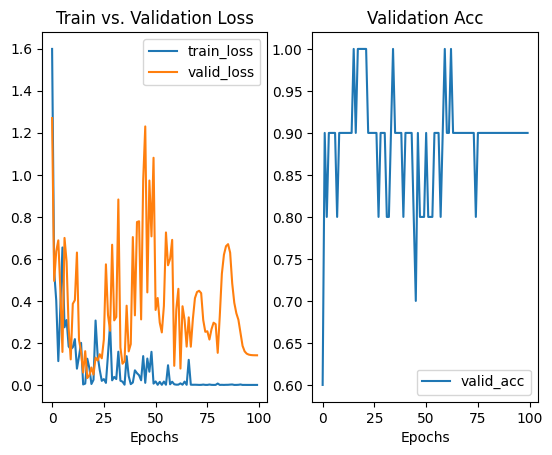

In [33]:
plt.subplot(1,2,1)
for key in  list(hist_dict.keys())[:-1]:
    plt.plot(hist_dict[key])
plt.legend(list(hist_dict.keys())[:-1])
plt.title('Train vs. Validation Loss')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
for key in  [list(hist_dict.keys())[-1]]:
    plt.plot(hist_dict[key])
plt.legend([list(hist_dict.keys())[-1]])
plt.title('Validation Acc')
plt.xlabel('Epochs')

<b> 4.5 Apply Model to Validation Dataset</b>

In [34]:
# apply model to validation dataset
predictions = trainer.predict(tokenized_data["test"])

# Extract the logits and labels from the predictions object
logits = predictions.predictions
labels = predictions.label_ids

# Use your compute_metrics function
#metrics = compute_metrics((logits, labels))
#print(metrics)
true_count = 0
for pred_l,actu_l in zip(labels,support_tickets_splits['test']['label']): 
    if pred_l == actu_l:
        true_count += 1
print(f'Accuracy {true_count/len(labels)}')

Accuracy 1.0


In [35]:
labels

array([2, 1, 1, 1, 1, 2, 2, 0, 1, 2], dtype=int64)

In [36]:
support_tickets_splits['test']['label']

[2, 1, 1, 1, 1, 2, 2, 0, 1, 2]

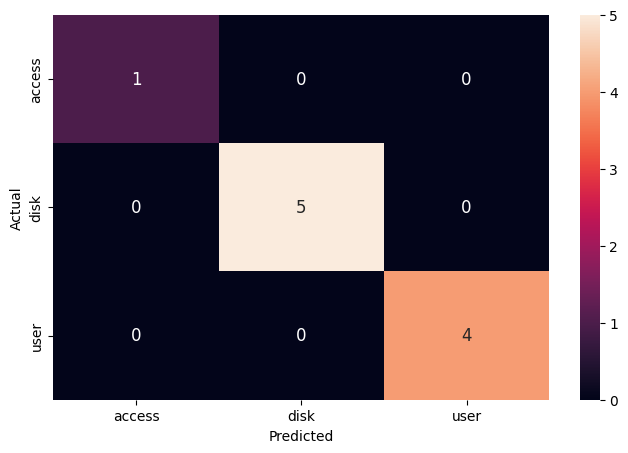

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

font_size = 12
label_class = ['access','disk','user']
cl_rep = classification_report(support_tickets_splits['test']['label'],
                               labels,
                               target_names=label_class,
                               output_dict=True
                            )

cm = confusion_matrix(support_tickets_splits['test']['label'],
                      labels)

plt.figure(figsize = (8, 5))
sns.heatmap(cm,
            xticklabels=label_class,
            yticklabels=label_class,
            annot = True,  fmt = '.0f',
            annot_kws={'size': font_size})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [38]:
df = pd.DataFrame(cl_rep)
df

,access,disk,user,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0,1.0
support,1.0,5.0,4.0,1.0,10.0,10.0


In [ ]:
# # push model to hub
# trainer.push_to_hub()